<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:300%;
           font-family:Verdana;
           letter-spacing:0.5px;">
        <p style="padding: 20px;
              color:white;text-align:center;">
            MobileNetV2 Transfer Learning with UTK Face Dataset</p>
    </div>


## 0. Introduction

The objective of this notebook is to train a CNN on UTK FAce dataset assisted by transfer Learning from Google's [Mobilenet-v2](https://www.kaggle.com/models/google/mobilenet-v2)

**Image Labels**

* The labels of each face image is embedded in the file name, formated like `[age]_[gender]_[race]_[date&time].jpg`

* `[age]` is an integer from 0 to 116, indicating the age

* `[gender]` is either 0 (male) or 1 (female)

* `[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

* `[date&time]` is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

<h2>1. Importing libraries</h2>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from random import randint
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

## 2. Pre-processing Images

In [2]:
path = "/kaggle/input/utk-face-cropped/utkcropped"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23710
26_0_2_20170104023102422.jpg.chip.jpg


In [3]:
images = []
ages = []
genders = []
ethnicity = []
for file in files:
    full_path = os.path.join(path, file)
    split_var = file.split('_')
    #print(split_var)
    try:
        if int(split_var[2]) < 150:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                # Load the image
                image = cv2.imread(full_path, 0)

                # Check if the image is loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, dsize=(128, 128), interpolation=cv2.INTER_AREA)
                    image = image.reshape((image.shape[0], image.shape[1], 1))
                    images.append(image)

        
    except (ValueError, IndexError) as e:
        continue
        
    ages.append(int(split_var[0]))
    genders.append(int(split_var[1]) )
    ethnicity.append(int(split_var[2]) )

Age : 45
Gender :  0
Ethnic :  1


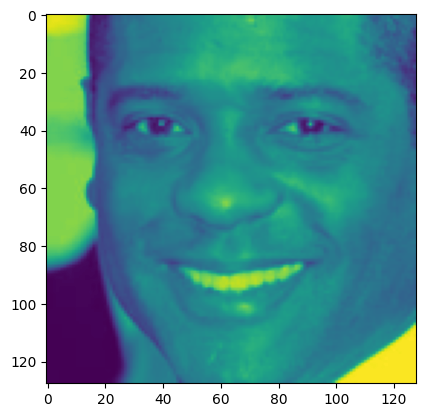

In [4]:
plt.imshow(images[876])
print("Age :",ages[876])
print("Gender : ",genders[876])
print("Ethnic : ",ethnicity[876])

An image example of a 45 years old Black man 😊

In [5]:
images_f = np.array(images)
ages_f = np.array(ages)
genders_f = np.array(genders)
ethnic_f = np.array(ethnicity)

## 2.1 Prepare training data and targets

In [6]:
target = np.zeros((len(images),3),dtype='int32')
features = np.zeros((len(images),images[0].shape[0],images[0].shape[1],3),dtype = 'float32')
for i in range(len(images)):
    target[i,0] = int(ages[i])
    target[i,1] = int(genders[i])
    target[i,2] = int(ethnicity[i])
    features[i] = images[i]
features = features / 255

features[12345].shape

(128, 128, 3)

## 3. EDA

In [7]:
df = pd.DataFrame({'features':images,'Age': ages_f, 'Gender': genders_f, 'Ethnic':ethnic_f})
df.describe()

,Age,Gender,Ethnic
count,23705.000000,23705.000000,23705.000000
mean,33.300907,0.477283,1.269226
std,19.885708,0.499494,1.345638
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000
75%,45.000000,1.000000,2.000000
max,116.000000,1.000000,4.000000


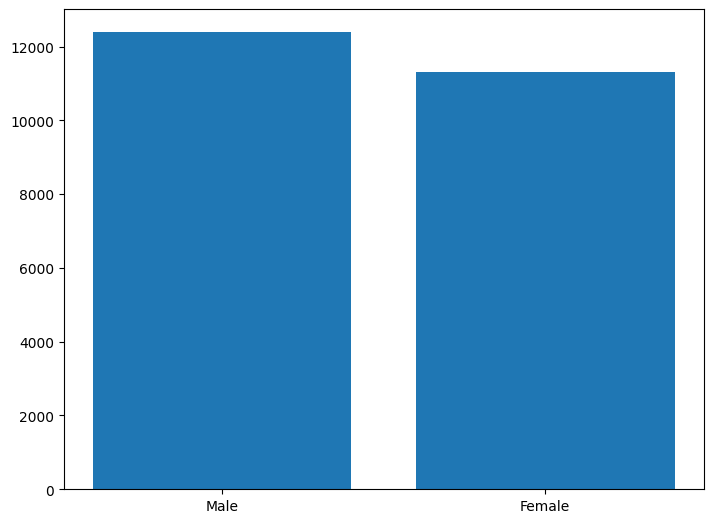

In [8]:
values, counts=np.unique(genders_f,return_counts=True)

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
gender=['Male','Female']
ax.bar(gender,counts)
plt.show()

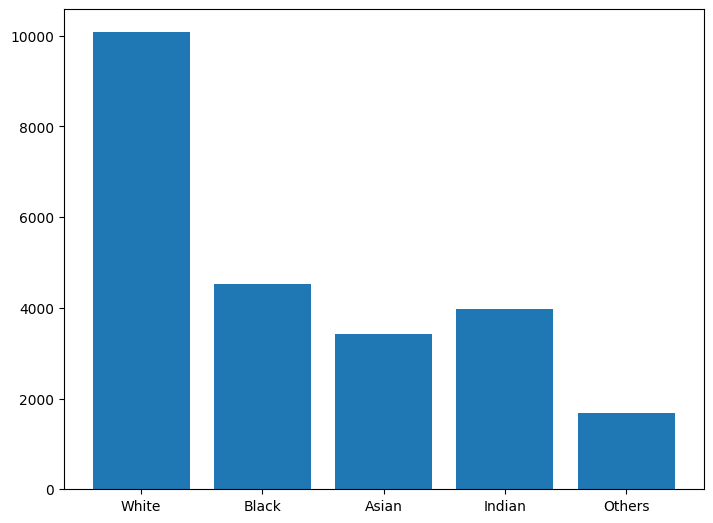

In [9]:
values, counts=np.unique(ethnic_f,return_counts=True)

fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ethnic=['White', 'Black', 'Asian', 'Indian', 'Others']
ax.bar(ethnic,counts)
plt.show()

In [10]:
import plotly.graph_objects as go
import plotly.express as px

## calculating distributions
age_dist = df['Age'].value_counts()
ethnicity_dist = df['Ethnic'].value_counts().rename({0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian',4:'Others'})
gender_dist = df['Gender'].value_counts().rename(index={0:'Male',1:'Female'})

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [11]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

Added an interactive plots example for fun

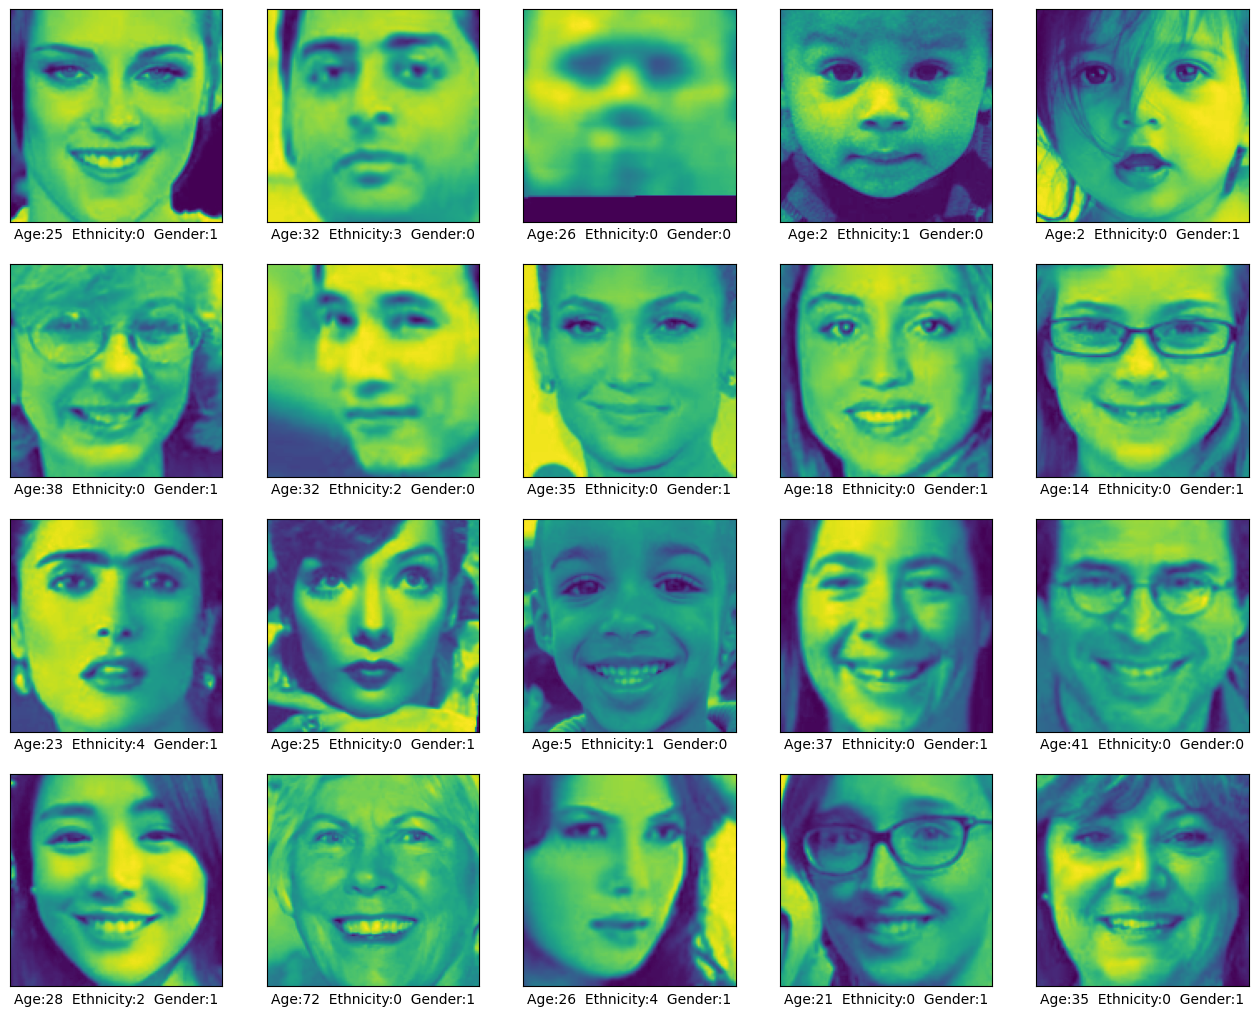

In [12]:
plt.figure(figsize=(16,16))
for i in range(5555,5575):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].reshape(128,128,1))
    plt.xlabel(
        "Age:"+str(df['Age'].iloc[i])+
        "  Ethnicity:"+str(df['Ethnic'].iloc[i])+
        "  Gender:"+ str(df['Gender'].iloc[i])
    )
plt.show()

## 4. Load the Model

In [13]:
model_name = "mobilenetv2-035-128"

#NOTICE HOW WE ARE USING FEATURE VECTOR FOR THIS STEP AND NOT CLASSIFIER
model_handle_map = {
  "mobilenetv2-035-128": "/kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2",
}

model_image_size_map = {
  "mobilenetv2-035-128": 128,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 128)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16

Selected model: mobilenetv2-035-128 : /kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2
Input size (128, 128)


In [14]:
# DEFINE TRAIN/TEST SPLIT
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (18964, 128, 128, 3)
train labels shape: (18964, 3)

validation images shape: (4741, 128, 128, 3)
validation labels shape: (4741, 3)



In [15]:
y_train[:5]

array([[26,  0,  2],
       [34,  1,  1],
       [26,  0,  1],
       [28,  1,  3],
       [ 1,  0,  2]], dtype=int32)

## 5. Model Building

In [16]:
# ImageDataGenerator for train images
train_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3,
                                                                         rotation_range=15,
                                                                         zoom_range=0.3,
                                                                         vertical_flip=True, 
                                                                         horizontal_flip=True)
train_images_generator = train_images_generator.flow(X_train, y=y_train)

# ImageDataGenerator for validation images
validation_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True, 
                                                                              horizontal_flip=True)
validation_images_generator = validation_images_generator.flow(X_val, y=y_val)

In [17]:
do_fine_tuning = False 
num_ethnicity_classes = 5

print("Building model with", model_handle)
# Define input layer
input_layer = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,))

# Load pre-trained model from TensorFlow Hub
hub_layer = hub.KerasLayer(model_handle, trainable=do_fine_tuning)(input_layer)
dropout_layer = tf.keras.layers.Dropout(rate=0.2)(hub_layer)

# Define output layers
fce = tf.keras.layers.Dense(200, activation='tanh')(dropout_layer)
ethnicity_output = tf.keras.layers.Dense(num_ethnicity_classes, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.0001), name='ethnicity_output')(fce)

fcg = tf.keras.layers.Dense(50, activation='relu')(dropout_layer)
gender_output = tf.keras.layers.Dense(1, activation='sigmoid', name='gender_output')(fcg)

fca = tf.keras.layers.Dense(100, activation='relu')(dropout_layer)
age_output = tf.keras.layers.Dense(1, activation='relu', name='age_output')(fca)


# Create the model
model = tf.keras.models.Model(inputs=input_layer, outputs=[age_output, gender_output, ethnicity_output])

model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with /kaggle/input/mobilenet-v2/tensorflow2/035-128-feature-vector/2
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 keras_layer (KerasLayer)    (None, 1280)                 410208    ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1280)                 0         ['keras_layer[0][0]']         
                                                                                                  
 dense_2 (Dense)             (None, 100)                  128100    ['dropout[0][0]']             
          

In [18]:
y_train[:, 0]

array([26, 34, 26, ..., 27, 46, 30], dtype=int32)

In [19]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}')

In [20]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

init_lr = 0.0001
opt = Adam(learning_rate=init_lr)
model.compile(optimizer=opt,
              loss={'age_output': 'mean_squared_error' ,
                    'gender_output': 'binary_crossentropy',
                    'ethnicity_output': 'sparse_categorical_crossentropy'
                    },
              metrics={'age_output': 'mae',
                      'gender_output': 'accuracy',
                       'ethnicity_output': 'accuracy'
                       })

train_size = X_train.shape[0]
valid_size = X_val.shape[0]
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    X_train,
    [y_train[:,0],y_train[:,1],y_train[:,2]],
    epochs=20,
    verbose=1,
    validation_data=(X_val,[y_val[:,0],y_val[:,1],y_val[:,2]]), 
    shuffle=True, callbacks=[checkpoint_callback])

Epoch 1/20
593/593 [==============================] - 61s 93ms/step - loss: 396.6004 - age_output_loss: 394.9239 - gender_output_loss: 0.5172 - ethnicity_output_loss: 1.1581 - age_output_mae: 14.8134 - gender_output_accuracy: 0.7438 - ethnicity_output_accuracy: 0.5552 - val_loss: 230.3879 - val_age_output_loss: 228.9474 - val_gender_output_loss: 0.4319 - val_ethnicity_output_loss: 1.0077 - val_age_output_mae: 11.5319 - val_gender_output_accuracy: 0.8005 - val_ethnicity_output_accuracy: 0.6298
Epoch 2/20
593/593 [==============================] - 49s 83ms/step - loss: 205.8362 - age_output_loss: 204.3849 - gender_output_loss: 0.4317 - ethnicity_output_loss: 1.0187 - age_output_mae: 10.9915 - gender_output_accuracy: 0.7990 - ethnicity_output_accuracy: 0.6176 - val_loss: 187.9095 - val_age_output_loss: 186.5455 - val_gender_output_loss: 0.4019 - val_ethnicity_output_loss: 0.9612 - val_age_output_mae: 10.4477 - val_gender_output_accuracy: 0.8108 - val_ethnicity_output_accuracy: 0.6473
Epoc

## 6. Model Evaluation

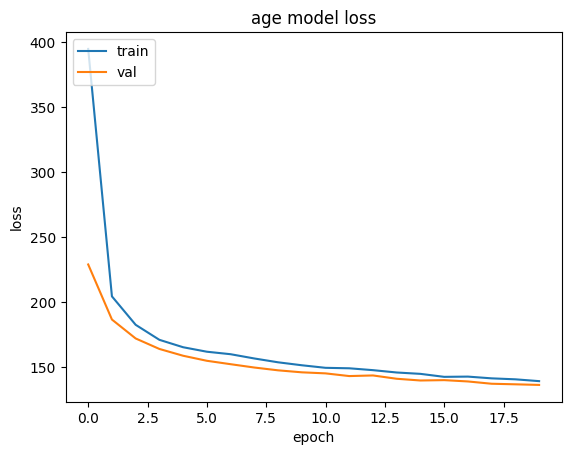

In [21]:
history = hist
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

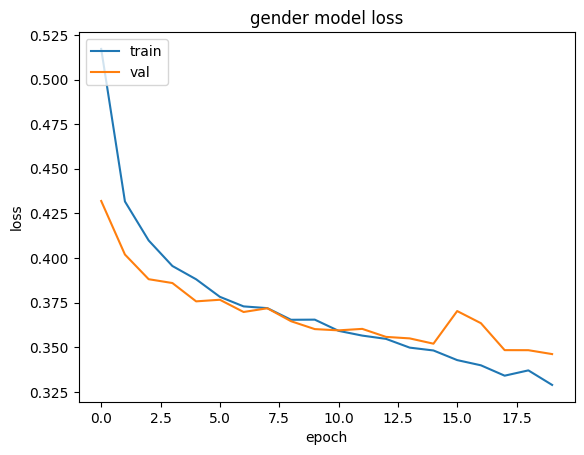

In [22]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

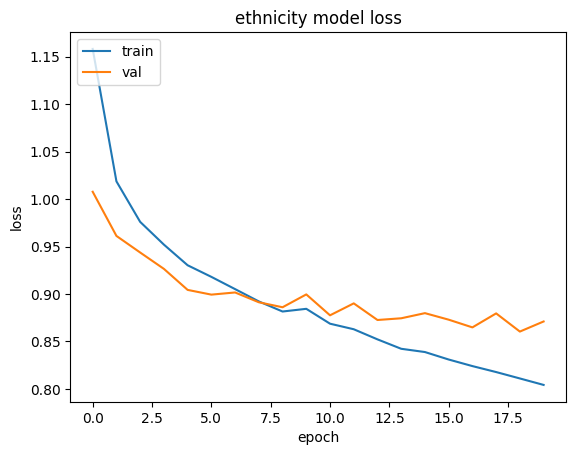

In [23]:
plt.plot(history.history['ethnicity_output_loss'])
plt.plot(history.history['val_ethnicity_output_loss'])
plt.title('ethnicity model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

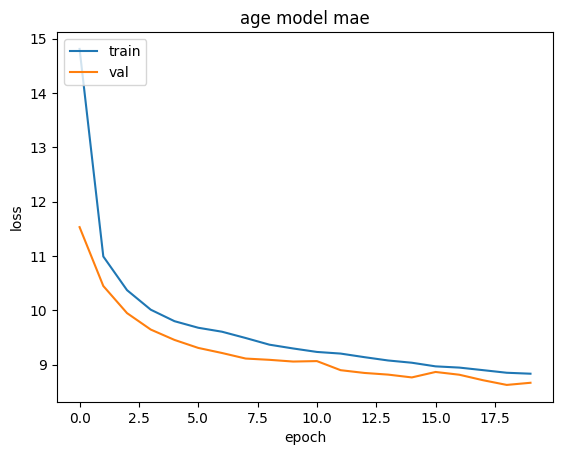

In [24]:
plt.plot(history.history['age_output_mae'])
plt.plot(history.history['val_age_output_mae'])
plt.title('age model mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

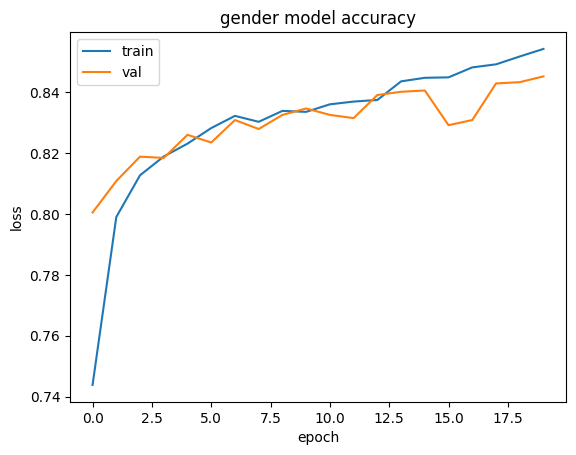

In [25]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

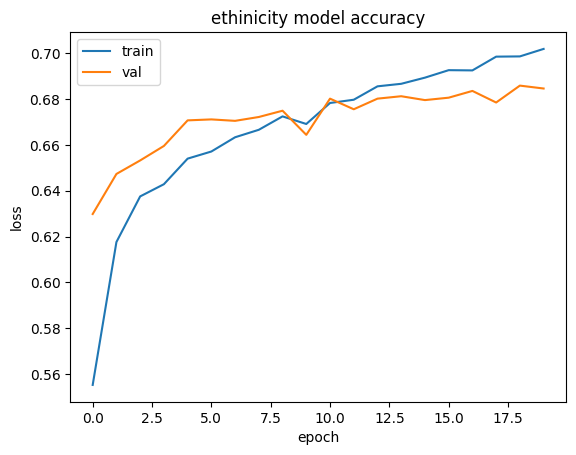

In [26]:
plt.plot(history.history['ethnicity_output_accuracy'])
plt.plot(history.history['val_ethnicity_output_accuracy'])
plt.title('ethinicity model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 6.1 Example Output

In [27]:
# Function to display images with predictions and true labels
import random
def display_random_images_with_predictions(images, true_labels, num_images=9):
    plt.figure(figsize=(15, 16))
    
    # Randomly select 'num_images' indices
    random_indices = random.sample(range(len(images)), num_images)
    test = np.array(features[random_indices])
    
    predictions = model.predict(test)
    
    for i, index in enumerate(random_indices, 1):
        plt.subplot(3, 3, i)
        plt.imshow(images[index])
        
        age_pred = int(np.round(predictions[0][i-1]))
        ethnicity_pred = int(np.argmax(predictions[2][i-1]))
        gender_pred = int(np.round(predictions[1][i-1]))
        
        plt.title(f"Age: Pred={age_pred}, True={int(true_labels[index, 0])}\nEthnicity: Pred={ethnicity_pred}, True={int(true_labels[index, 2])}\nGender: Pred={gender_pred}, True={int(true_labels[index, 1])}")
        plt.axis('off')
    
    plt.show()



1/1 [==============================] - 1s 628ms/step


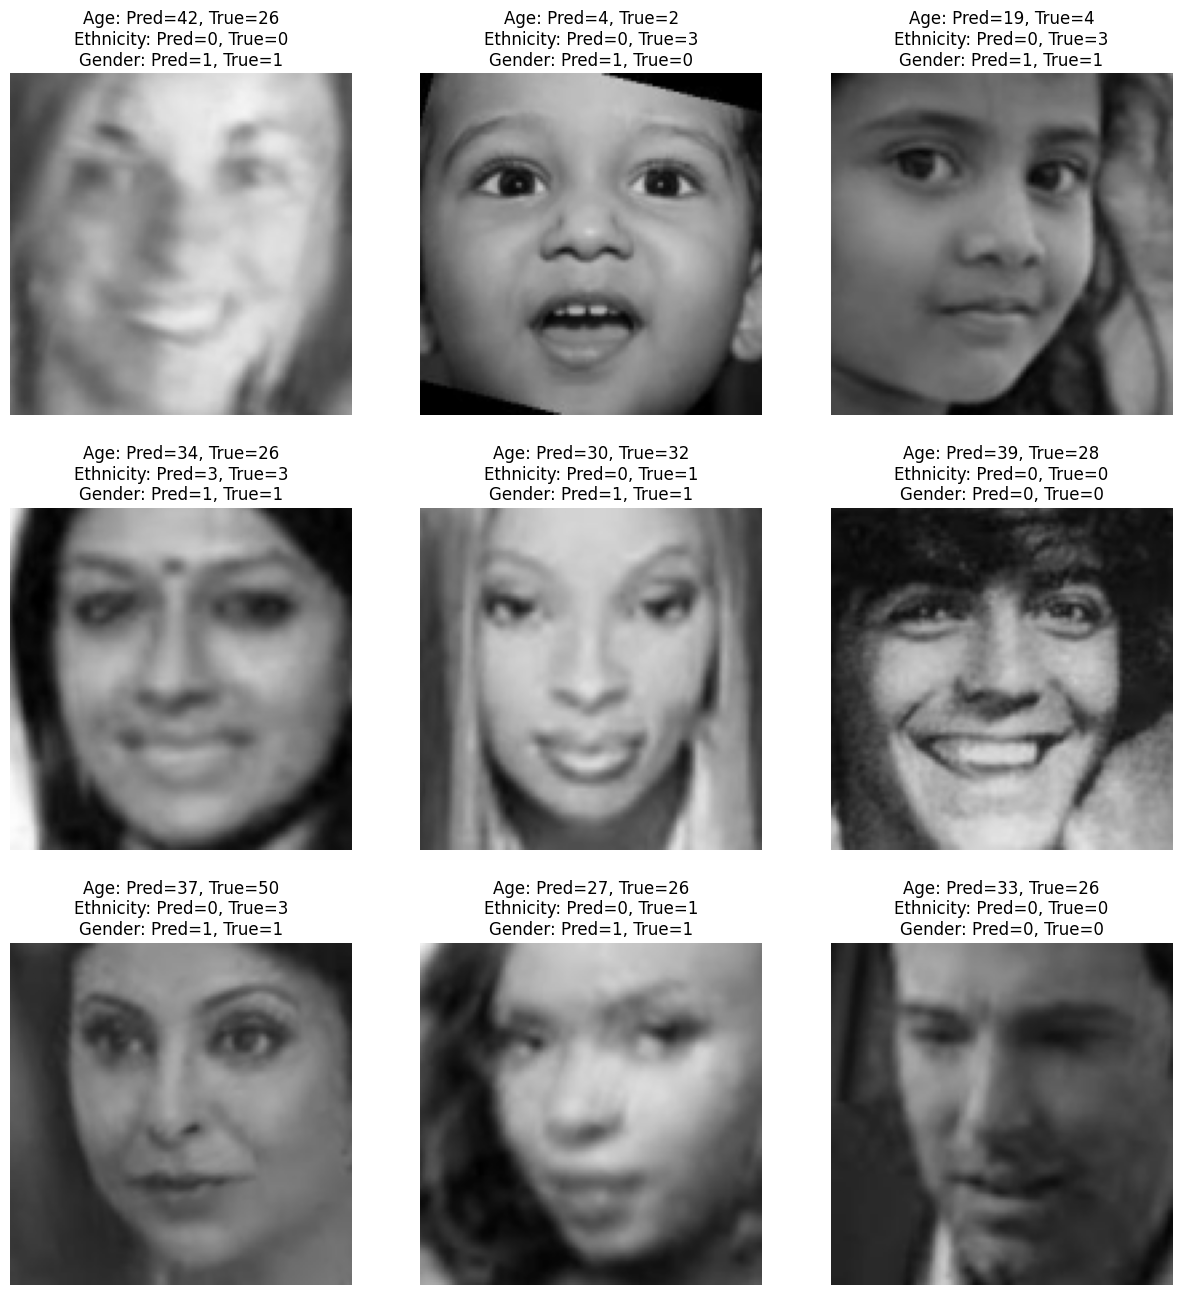

In [28]:
images_to_display = features  
display_random_images_with_predictions(images_to_display, target)

## 7. Conclusion

So we get about 84% accuracy on gender output, 68% accuracy on ethincity output and about 8 MAE on age output.<br />Considering quite a buch of the mislabelled data, not bad for a baseline model!

In [29]:
model.save('model.h5')
#model.save_weights('./weights/my_checkpoint')
# model.save('saved_model/my_model')
# model.save('model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [30]:
# import shutil
# shutil.make_archive('/kaggle/working/saved_model', 'zip', '/kaggle/working/')
